## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 15.7 MB/s eta 0:00:00


In [ ]:
import os
import random
import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
import torchmetrics as tm
from sklearn.model_selection import train_test_split
import torchaudio
from torchaudio import transforms as T
from torchaudio import pipelines
import librosa
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Audio
import warnings
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
for lib in [torch, torchaudio, librosa, pd]:
    print(lib.__name__ ,lib.__version__)

torch 2.5.1+cu121
torchaudio 2.5.1+cu121
librosa 0.10.2.post1
pandas 2.2.2


## Dataset

In [ ]:
# load a sample and hearing its contents

sound, sr = torchaudio.load('drive/MyDrive/aug_shemo/F01A01_speed_1.3.wav')
print(sound.shape)
Audio(data=sound, rate=sr)

torch.Size([1, 51337])


torch.Size([128, 257])


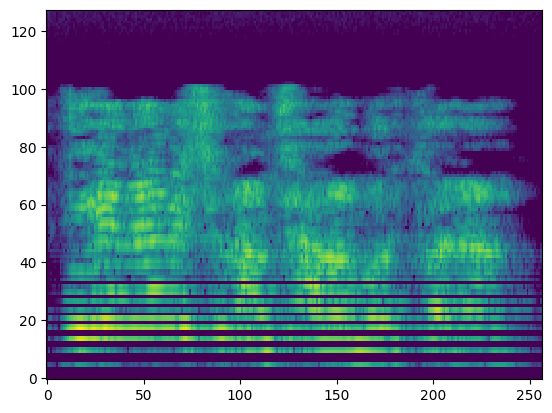

In [ ]:
# plot mel-spectrogram
transform = T.MelSpectrogram(sample_rate=sr, n_fft=400, n_mels=128)
mel = transform(sound)
print(mel[0].shape)
plt.imshow(librosa.power_to_db(mel[0]), origin="lower", aspect="auto", interpolation="nearest")

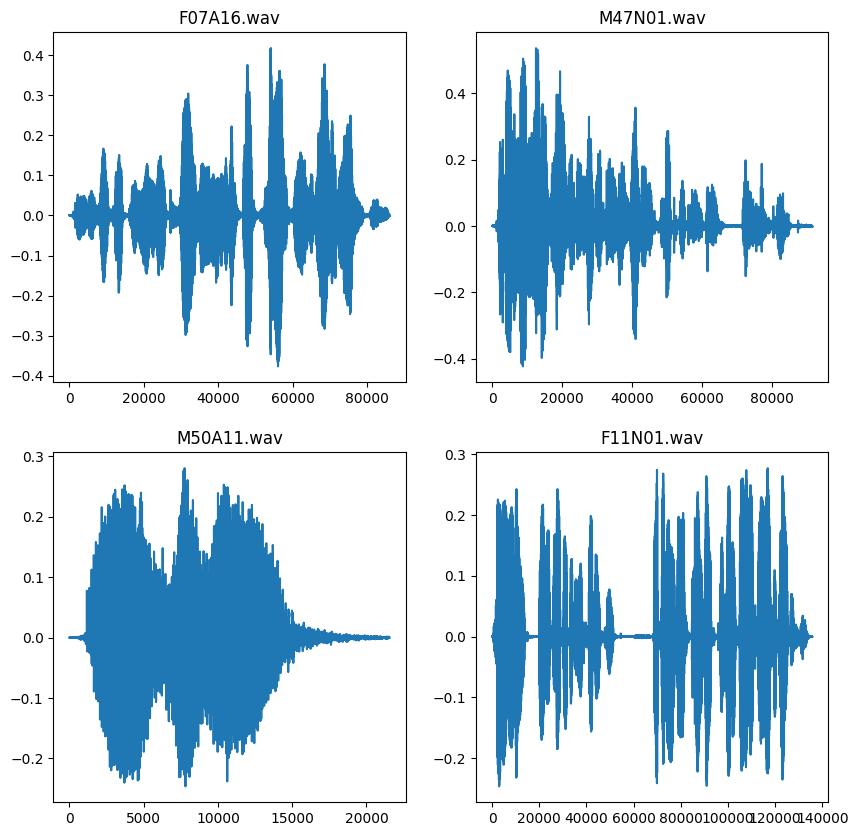

In [ ]:
# plot some random sounds in dataset

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes_flatten = axes.flatten()

for i in range(len(axes_flatten)):
    data = random.choice(file_names)
    sound, sr = librosa.load(f'SHEMO/{data}')
    axes_flatten[i].plot(sound)
    axes_flatten[i].set_title(data)

In [ ]:
# create a dataframe of our sounds

def make_csv(dataset_folder):

    names = []
    genders = []
    emotions = []

    file_names = os.listdir(dataset_folder)

    for file in file_names:
        info = file.split('_')[0]
        gender = 0 if info[0] == 'F' else 1 # 0 for Female and 1 for male
        emotion = info[3] # S = sadness, A = anger, H = happiness, W = surprise, F = fear, N = neutral

        names.append(f'{dataset_folder}/{file}')
        genders.append(gender)
        emotions.append(emotion)

    df = pd.DataFrame({
        'sound_name': names,
        'gender': genders,
        'emotion': emotions
    })

    return df


In [ ]:
df = make_csv(dataset_folder='drive/MyDrive/aug_shemo')
df

,sound_name,gender,emotion
0,drive/MyDrive/aug_shemo/F22F01_speed_1.0.wav,0,F
1,drive/MyDrive/aug_shemo/F22F01_speed_1.3.wav,0,F
2,drive/MyDrive/aug_shemo/F22F01_pitch_-2.wav,0,F
3,drive/MyDrive/aug_shemo/F22F01_pitch_0.wav,0,F
4,drive/MyDrive/aug_shemo/F22F01_pitch_2.wav,0,F
...,...,...,...
21240,drive/MyDrive/aug_shemo/M20N06_speed_1.3.wav,1,N
21241,drive/MyDrive/aug_shemo/M20N06_pitch_-2.wav,1,N
21242,drive/MyDrive/aug_shemo/M20N06_pitch_0.wav,1,N
21243,drive/MyDrive/aug_shemo/M20N06_pitch_2.wav,1,N


In [ ]:
# encoding the emotion column in df
def emotion_encoder(x):
    emotions_dict = {
    'S': 0, # Sadness
    'A': 1, # Angry
    'H': 2, # Happiness
    'N': 3, # Neutral
    'F': 4, # Fear
    'W': 5 # Surprize
    }

    return int(emotions_dict.get(x))

df['emotion'] = df['emotion'].apply(emotion_encoder)
df

,sound_name,gender,emotion
0,drive/MyDrive/aug_shemo/F22F01_speed_1.0.wav,0,4
1,drive/MyDrive/aug_shemo/F22F01_speed_1.3.wav,0,4
2,drive/MyDrive/aug_shemo/F22F01_pitch_-2.wav,0,4
3,drive/MyDrive/aug_shemo/F22F01_pitch_0.wav,0,4
4,drive/MyDrive/aug_shemo/F22F01_pitch_2.wav,0,4
...,...,...,...
21240,drive/MyDrive/aug_shemo/M20N06_speed_1.3.wav,1,3
21241,drive/MyDrive/aug_shemo/M20N06_pitch_-2.wav,1,3
21242,drive/MyDrive/aug_shemo/M20N06_pitch_0.wav,1,3
21243,drive/MyDrive/aug_shemo/M20N06_pitch_2.wav,1,3


In [ ]:
df = df[~df['emotion'].isin([4, 5])]
df

,sound_name,gender,emotion
13,drive/MyDrive/aug_shemo/F22S02_speed_0.7.wav,0,0
14,drive/MyDrive/aug_shemo/F22S02_speed_1.0.wav,0,0
15,drive/MyDrive/aug_shemo/F22S02_speed_1.3.wav,0,0
16,drive/MyDrive/aug_shemo/F22S02_pitch_-2.wav,0,0
17,drive/MyDrive/aug_shemo/F22S02_pitch_0.wav,0,0
...,...,...,...
21240,drive/MyDrive/aug_shemo/M20N06_speed_1.3.wav,1,3
21241,drive/MyDrive/aug_shemo/M20N06_pitch_-2.wav,1,3
21242,drive/MyDrive/aug_shemo/M20N06_pitch_0.wav,1,3
21243,drive/MyDrive/aug_shemo/M20N06_pitch_2.wav,1,3


In [ ]:
df = df[df['gender']==1]
df

,sound_name,gender,emotion
7000,drive/MyDrive/aug_shemo/M16A25_speed_1.0.wav,1,1
7001,drive/MyDrive/aug_shemo/M16A25_speed_1.3.wav,1,1
7002,drive/MyDrive/aug_shemo/M16A25_pitch_-2.wav,1,1
7003,drive/MyDrive/aug_shemo/M16A25_pitch_0.wav,1,1
7004,drive/MyDrive/aug_shemo/M16A25_pitch_2.wav,1,1
...,...,...,...
21240,drive/MyDrive/aug_shemo/M20N06_speed_1.3.wav,1,3
21241,drive/MyDrive/aug_shemo/M20N06_pitch_-2.wav,1,3
21242,drive/MyDrive/aug_shemo/M20N06_pitch_0.wav,1,3
21243,drive/MyDrive/aug_shemo/M20N06_pitch_2.wav,1,3


In [ ]:
labels = df['emotion'].values

class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)

In [ ]:
class_weights

array([2.26966292, 0.66887417, 4.48888889, 0.54301075])

### EDA

In [ ]:
df.describe()

,gender,emotion
count,21245.000000,21245.000000
mean,0.572323,2.468863
std,0.494753,1.979663
min,0.000000,0.000000
25%,0.000000,1.000000
50%,1.000000,1.000000
75%,1.000000,5.000000
max,1.000000,5.000000


<Axes: >

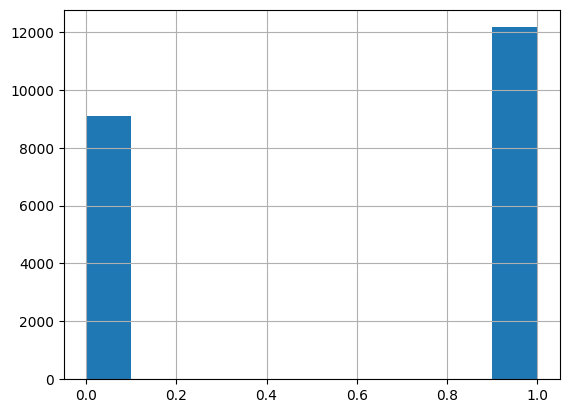

In [ ]:
df['gender'].hist()

<Axes: >

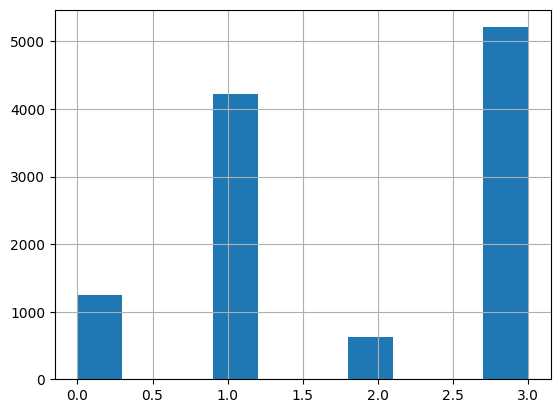

In [ ]:
df['emotion'].hist()

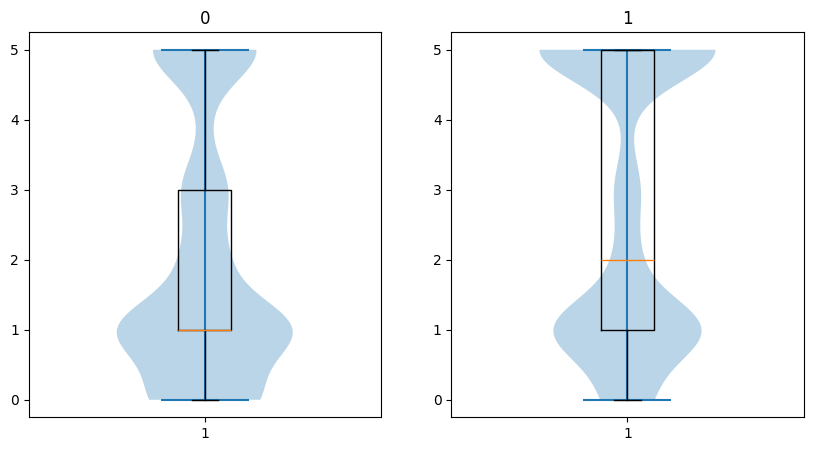

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

for i, gender in zip(range(2), [0, 1]):

    axes[i].violinplot(df['emotion'][df['gender'] == gender])
    axes[i].boxplot(df['emotion'][df['gender'] == gender])
    axes[i].set_title(gender)

### Split dataset

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['emotion'], random_state=42)
df_test, df_valid = train_test_split(df_test, test_size=0.5, stratify=df_test['emotion'], random_state=42)

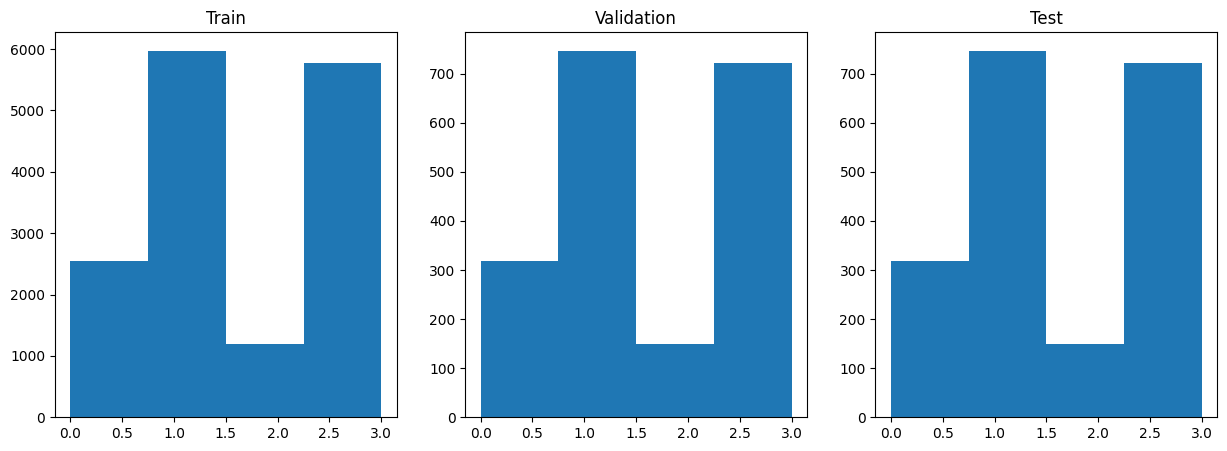

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(df_train.emotion, bins=len(df_train.emotion.unique())); axes[0].set_title('Train')
axes[1].hist(df_valid.emotion, bins=len(df_valid.emotion.unique())); axes[1].set_title('Validation')
axes[2].hist(df_test.emotion, bins=len(df_test.emotion.unique())); axes[2].set_title('Test');

### save the training, test and validation sets in separate CSV file

In [ ]:
df_train.to_csv('./train_set.csv', index=False)
df_valid.to_csv('./valid_set.csv', index=False)
df_test.to_csv('./test_set.csv', index=False)

### Custom Dataset

In [ ]:
class SHEMO(Dataset):

    def __init__(self, root_dir, csv_file, duration, sample_rate):
        super().__init__()
        self.root_dir = root_dir
        self.csv_file = csv_file
        self.data = pd.read_csv(f'{self.root_dir}/{self.csv_file}')
        self.duration = duration
        self.sample_rate = sample_rate

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
      sample = self.data.iloc[idx, :]
      sound, sr = torchaudio.load(sample.sound_name)
      sound = torchaudio.functional.resample(sound, sr, self.sample_rate)
      emotion = torch.tensor(sample.emotion, dtype=torch.float32)

      if sound.shape[1] <= int(self.duration * self.sample_rate):
        pad = torch.zeros(self.duration * self.sample_rate)
        pad[:sound.shape[1]] = sound
        data = pad
        data = data.unsqueeze(0)
      else:
        cutted = sound[:, :(self.duration * self.sample_rate)]
        data = cutted

      return data, emotion

In [ ]:
# testing the custom dataset

ex = SHEMO('./', 'train_set.csv', 5, 22000)
print(ex.__len__())
x, y = ex[0]
x.shape, y

15495


(torch.Size([1, 110000]), tensor(3.))

In [ ]:
# Defining the train, valid and test set; Using our custom dataset(SHEMO)
duration = 5
sample_rate = 16000

train_set = SHEMO(root_dir='./', csv_file='train_set.csv', duration=duration, sample_rate=sample_rate)
valid_set = SHEMO(root_dir='./', csv_file='valid_set.csv', duration=duration, sample_rate=sample_rate)
test_set = SHEMO(root_dir='./', csv_file='test_set.csv', duration=duration, sample_rate=sample_rate)

### DataLoader

In [ ]:
transform = T.MelSpectrogram(sample_rate=sample_rate, n_fft=512, n_mels=128, hop_length=128)

In [ ]:
def collate_fn(batch):
  x = []
  labels = []

  for data, label in batch:
    data = librosa.effects.preemphasis(np.array(data))
    data = librosa.util.normalize(np.array(data), axis=1)
    mel_specgram = transform(torch.tensor(data))
    x.append(mel_specgram)
    labels.append(label)

  data = torch.stack(x)
  labels = [torch.tensor(l, dtype=torch.int64) for l in labels]
  labels = torch.tensor(labels)

  return data, labels

In [ ]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_set, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [ ]:
# getting a batch from train_loader and test it
x, y = next(iter(train_loader))

x.shape, y

(torch.Size([16, 1, 128, 626]),
 tensor([1, 1, 1, 0, 0, 1, 3, 3, 1, 3, 1, 1, 1, 0, 1, 3]))

## Model

In [ ]:
class Cnn_Lstm_Model(nn.Module):
    def __init__(self,num_emotions):

        super().__init__()
        self.num_emotions = num_emotions
        self.conv2Dblock = torchvision.models.resnet50()
        self.conv2Dblock.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.features = nn.Sequential(*(list(self.conv2Dblock.children())[:-1]))
        self.lstm = nn.LSTM(input_size=2048, hidden_size=128, num_layers=1, batch_first=True)
        self.fc = nn.LazyLinear(self.num_emotions)
        self.lstm_maxpool = nn.MaxPool2d(kernel_size=[2,4], stride=[2,4])

    def forward(self, x):

      y = self.features(x)
      y = y.flatten(2)
      y, _ = self.lstm(y.permute(0, 2, 1))
      y = self.fc(y)
      y = y.mean(dim=1)
      return y

## Functions

In [ ]:
class AverageMeter(object):

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):

  model.train()
  loss_train = AverageMeter()
  metric.reset()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:

      inputs = inputs.to(device)
      targets = targets.to(device)

      if epoch:
        tepoch.set_description(f'Epoch {epoch}')

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)
      loss.backward()

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      metric.update(outputs, targets)
      tepoch.set_postfix(loss=loss_train.avg, metric=metric.compute().item())

  return model, loss_train.avg, metric.compute().item()

In [ ]:
def evaluate(model, test_loader, loss_fn, metric):
  model.eval()
  loss_eval = AverageMeter()
  metric.reset()

  with torch.no_grad():
    for inputs, targets in test_loader:

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)
      loss_eval.update(loss.item(), n=len(targets))
      metric.update(outputs, targets)

  return loss_eval.avg, metric.compute().item()

## Config

In [ ]:
num_emotions = 4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Cnn_Lstm_Model(num_emotions=num_emotions).to(device)

loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float))
optimizer = optim.Adam(lr=0.001, params=model.parameters())
metric = tm.Accuracy(task='multiclass', num_classes=num_emotions).to(device)

print(f'device: {device}')
print(f'loss function: {loss_fn}')
print(f'metric: {metric}')
print(f'optimizer: {optimizer}')

device: cpu
loss function: CrossEntropyLoss()
metric: MulticlassAccuracy()
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


## Training process

### Finding Hyper-parameters

Calculating the loss for an untrained model using a few batches.

In [ ]:
for i, (x_b, y_b) in zip(range(3), train_loader):
  with torch.no_grad():
    outputs = model(x_b)
    loss = loss_fn(outputs, y_b)
    print(f'loss: {loss}')

loss: 1.438765287399292
loss: 1.4473789930343628
loss: 1.4326714277267456


Try to train and overfit the model on a small subset of the dataset.

In [ ]:
len(train_set)

15495

In [ ]:
mini_dataset, _ = random_split(train_set, [len(train_set)-15000, 15000])
mini_loader = DataLoader(mini_dataset, 4, True, collate_fn=collate_fn)

In [ ]:
len(mini_dataset)

495

In [ ]:
torch.cuda.empty_cache()

In [ ]:
n_epochs = 3

for epoch in range(n_epochs):
  model, _, _ = train_one_epoch(model,
                                mini_loader,
                                loss_fn,
                                optimizer,
                                metric,
                                epoch)

Epoch 1:  16%|█▌        | 20/124 [01:28<07:39,  4.42s/batch, loss=1.25, metric=0.438]


KeyboardInterrupt: 

Train the model for a limited number of epochs, experimenting with various learning rates.

In [ ]:
lrs = [0.001, 0.0001, 0.00001]
n_epochs = 2

for lr in lrs:
  model = Cnn_Lstm_Model(num_emotions=num_emotions).to(device)
  optimizer = optim.Adam(lr=lr, params=model.parameters())
  print(f'Lr: {lr}')
  for epoch in range(n_epochs):
    model, _, _ = train_one_epoch(model,
                                  train_loader,
                                  loss_fn,
                                  optimizer,
                                  metric)

Lr: 0.001


100%|██████████| 38/38 [05:23<00:00,  8.51s/batch, loss=1.2, metric=0.563]


Lr: 0.0001


100%|██████████| 38/38 [05:26<00:00,  8.60s/batch, loss=1.51, metric=0.48]


Lr: 1e-05


100%|██████████| 38/38 [05:26<00:00,  8.61s/batch, loss=1.73, metric=0.369]


Train model for longer epochs.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
model = Cnn_Lstm_Model(num_emotions=num_emotions).to(device)

Acc_train_hist = []
Acc_valid_hist = []
loss_train_hist = []
loss_valid_hist = []

best_loss = np.inf

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_emotions = 4
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float).to(device))
metric = tm.Accuracy(task='multiclass', num_classes=num_emotions).to(device)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
for lr in [0.00005, 0.000001, 0.0000005, 0.0000001]:
  n_epochs = 5
  optimizer = optim.Adam(lr=lr, params=model.parameters())

  for epoch in range(n_epochs):

    model, loss_train, Acc_train = train_one_epoch(model,
                                    train_loader,
                                    loss_fn,
                                    optimizer,
                                    metric,
                                    epoch)
    Acc_train_hist.append(Acc_train)
    loss_train_hist.append(loss_train)

    loss_valid, Acc_valid = evaluate(model, valid_loader, loss_fn, metric)

    Acc_valid_hist.append(Acc_valid)
    loss_valid_hist.append(loss_valid)

    print(f'Acc_valid: {Acc_valid:.4}')
    print(f'loss_valid: {loss_valid:.4}')

    if loss_valid < best_loss:
      best_loss = loss_valid
      torch.save(model, 'drive/MyDrive/model_weight_balanced_aug.pt')
      print('model saved!')

    torch.cuda.empty_cache()

100%|██████████| 283/283 [06:01<00:00,  1.28s/batch, loss=0.773, metric=0.701]


Acc_valid: 0.6564
loss_valid: 0.846
model saved!


Epoch 1: 100%|██████████| 283/283 [06:03<00:00,  1.29s/batch, loss=0.765, metric=0.696]


Acc_valid: 0.6564
loss_valid: 0.8821


Epoch 2: 100%|██████████| 283/283 [06:02<00:00,  1.28s/batch, loss=0.745, metric=0.704]


Acc_valid: 0.5707
loss_valid: 0.9713


Epoch 3: 100%|██████████| 283/283 [06:00<00:00,  1.27s/batch, loss=0.735, metric=0.702]


Acc_valid: 0.7032
loss_valid: 0.7629
model saved!


Epoch 4: 100%|██████████| 283/283 [06:02<00:00,  1.28s/batch, loss=0.73, metric=0.699]


Acc_valid: 0.7147
loss_valid: 0.749
model saved!


100%|██████████| 283/283 [06:01<00:00,  1.28s/batch, loss=0.715, metric=0.706]


Acc_valid: 0.6899
loss_valid: 0.7998


Epoch 1: 100%|██████████| 283/283 [06:03<00:00,  1.28s/batch, loss=0.709, metric=0.715]


Acc_valid: 0.6661
loss_valid: 0.8724


Epoch 2: 100%|██████████| 283/283 [06:02<00:00,  1.28s/batch, loss=0.708, metric=0.715]


Acc_valid: 0.5565
loss_valid: 1.132


Epoch 3: 100%|██████████| 283/283 [06:01<00:00,  1.28s/batch, loss=0.713, metric=0.711]


Acc_valid: 0.6961
loss_valid: 0.7797


Epoch 4: 100%|██████████| 283/283 [06:02<00:00,  1.28s/batch, loss=0.7, metric=0.716]


Acc_valid: 0.6696
loss_valid: 0.8397


100%|██████████| 283/283 [06:01<00:00,  1.28s/batch, loss=0.711, metric=0.719]


Acc_valid: 0.5389
loss_valid: 1.201


Epoch 1: 100%|██████████| 283/283 [06:02<00:00,  1.28s/batch, loss=0.71, metric=0.714]


Acc_valid: 0.6343
loss_valid: 0.9185


Epoch 2: 100%|██████████| 283/283 [06:00<00:00,  1.28s/batch, loss=0.708, metric=0.72]


Acc_valid: 0.7085
loss_valid: 0.7556


Epoch 3: 100%|██████████| 283/283 [06:00<00:00,  1.27s/batch, loss=0.705, metric=0.718]


Acc_valid: 0.5442
loss_valid: 1.157


Epoch 4: 100%|██████████| 283/283 [06:00<00:00,  1.27s/batch, loss=0.713, metric=0.715]


Acc_valid: 0.6352
loss_valid: 0.922


100%|██████████| 283/283 [05:59<00:00,  1.27s/batch, loss=0.711, metric=0.72]


Acc_valid: 0.621
loss_valid: 0.9577


Epoch 1: 100%|██████████| 283/283 [06:01<00:00,  1.28s/batch, loss=0.722, metric=0.715]


Acc_valid: 0.5892
loss_valid: 1.022


Epoch 2: 100%|██████████| 283/283 [06:00<00:00,  1.27s/batch, loss=0.707, metric=0.716]


Acc_valid: 0.6864
loss_valid: 0.8298


Epoch 3: 100%|██████████| 283/283 [06:00<00:00,  1.27s/batch, loss=0.703, metric=0.716]


Acc_valid: 0.6396
loss_valid: 0.9058


Epoch 4: 100%|██████████| 283/283 [06:01<00:00,  1.28s/batch, loss=0.707, metric=0.717]


Acc_valid: 0.5848
loss_valid: 1.027


In [ ]:
loaded_model = torch.load('drive/MyDrive/model_weight_balanced_aug.pt', map_location='cpu')
loss, metric = evaluate(loaded_model, test_loader, loss_fn, metric)
print(f'loss: {loss:.4}')
print(f'Accuracy: {metric:.4}')

loss: 0.7928
Accuracy: 0.6985


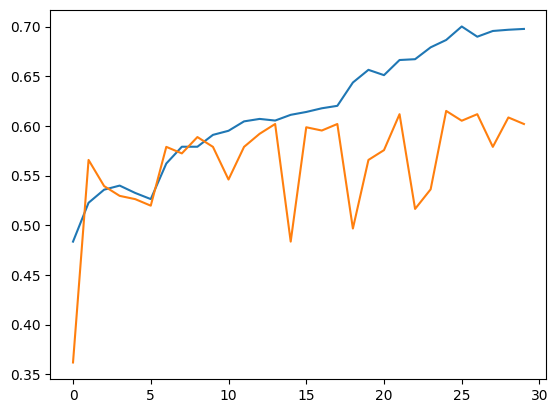

In [ ]:
plt.plot(Acc_train_hist)
plt.plot(Acc_valid_hist)

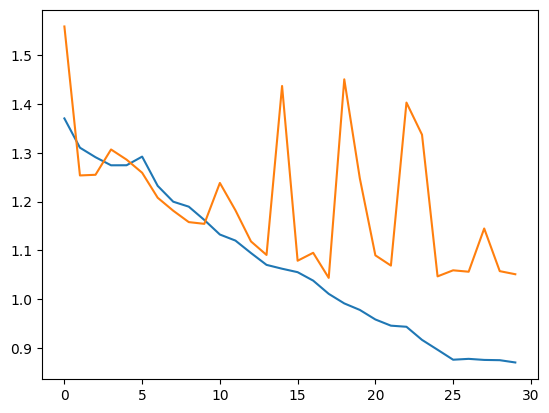

In [ ]:
plt.plot(loss_train_hist)
plt.plot(loss_valid_hist)